In [40]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import binned_statistic_dd, truncnorm
import pandas as pd
from collections import Counter
from itertools import product
import os
import sys
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
sys.path.append("../data_extraction/")
from utils import flatten_logic

In [2]:
FEATURE_COLUMNS = ['Valence', 'Arousal', 'Dominance', 'Politeness', 'Formality']

In [3]:
def get_bins(data, num_bins):
    """Return the bin index that each data point in data falls into, given the space
    is subdivided to have num_bins equally sized bins.

    A bin number of i means that the corresponding value is between bin_edges[i-1], bin_edges[i]

    Returns both the bin index as a unique integer, as well as in terms of a 5d
    array corresponding to each dimension.
    """
    # Initialize uniformly-sized bins
    bin_edges = np.linspace(0, 1, (num_bins + 1))

    # We need to know where in the space each bin id maps to, so edges are necessary

    # TO DO: Can we modify the statistic to directly calculate a vector valued statistic?
    stats, edges, binnumber = binned_statistic_dd(data, np.arange(len(data)),
                                                  statistic="mean",
                                                  bins=[bin_edges for i in range(data.shape[1])])
    
    stats, edges, unraveled_binnumber = binned_statistic_dd(data, np.arange(len(data)),
                                                            statistic="mean",
                                                            bins=[bin_edges for i in range(data.shape[1])],
                                                            expand_binnumbers=True)

    # Return the bin IDs
    return binnumber, unraveled_binnumber.transpose()

In [71]:
ROOT_DIR = "/ais/hal9000/datasets/reddit/stance_pipeline/nov_27_test_run/full_features/"
files = sorted(os.listdir(ROOT_DIR))
dfs = []
for file in files:
    df = pd.read_csv(ROOT_DIR + file)
    dfs.append(df)
df = pd.concat(dfs)
del dfs
df = df.set_index("id")
df['rel_marker'] = df['rel_marker'].apply(lambda x: eval(x)[0])
df['Politeness'] = (df["Politeness"] - df['Politeness'].min())/(df['Politeness'].max() - df['Politeness'].min()) 

In [72]:
from scipy.stats import spearmanr
spearmanr(df['Politeness'], df["Valence"])

SpearmanrResult(correlation=0.40008980135133987, pvalue=0.0)

In [73]:
bins, ubins = get_bins(df[FEATURE_COLUMNS].to_numpy(), 2)

In [74]:
def get_bin_names(arr):
    features = np.array(list("VADPF"))
    added = np.char.add(features, arr.astype(str))
    names = np.sum(added.astype(object), axis=1)
    return names
    
df['bin'] = get_bin_names(ubins)

In [75]:
df['bin'].describe()

count        7138111
unique            32
top       V1A2D1P1F1
freq         1414944
Name: bin, dtype: object

In [78]:
df['bin'].describe()

count        7138111
unique            32
top       V1A2D1P1F1
freq         1414944
Name: bin, dtype: object

In [79]:
x = df.groupby("bin")[FEATURE_COLUMNS].mean()

In [150]:
x.to_csv(ROOT_DIR + "output/original_space_data.csv")

In [80]:
all_markers = sorted(df['rel_marker'].unique())

In [81]:
agg = df.groupby(["subreddit", "bin", "rel_marker"]).count()

In [82]:
df['sub_marker'] = df["subreddit"] + "_" + df['rel_marker']

In [83]:
agg = df.groupby(["bin", "sub_marker"]).count()

In [84]:
comms = df['subreddit'].unique()
markers = df['rel_marker'].unique()
bins = df['bin'].unique()
com_markers = list(product(comms, markers))
com_markers = ["_".join(pair) for pair in com_markers]
len(com_markers)

4540

In [85]:
full_counts = pd.DataFrame(0, index=pd.MultiIndex.from_product([bins, com_markers], names=["bin", "sub_marker"]), columns=agg.columns)

In [86]:
total = agg.add(full_counts, fill_value=0)

In [87]:
total = total.reset_index()

In [88]:
cooc_matrix = pd.crosstab(total['bin'], total['sub_marker'], total['body'], aggfunc="sum")

In [89]:
np.count_nonzero(cooc_matrix)/cooc_matrix.size

0.38310848017621146

In [90]:
all_subs = []
for i in range(len(comms)):
    sub = cooc_matrix.iloc[:, i*len(markers):(i+1)*len(markers)]
    sub.columns = [col[col.index("_") + 1:] for col in sub.columns]
    all_subs.append(sub)

In [22]:
from functools import reduce

In [125]:
whole_counts = reduce(lambda a, b: a.add(b, fill_value=0), all_subs)

In [126]:
whole_agg = whole_counts.sum()
markers_to_keep = whole_agg.index#set(whole_agg[whole_agg >= 100].index)

In [295]:
whole_agg[whole_agg >= 10000].shape

(17,)

In [195]:
cooc_matrix.columns[0]#.find("/")

'actrade_afraid'

In [211]:
cooc_matrix.columns[0][ cooc_matrix.columns[0].find("_") + 1:] 

'afraid'

In [212]:
cooc_matrix = cooc_matrix[[col for col in cooc_matrix.columns if col[col.find("_") + 1:] in markers_to_keep]]

In [91]:
cooc_matrix

sub_marker,baseball_afraid,baseball_aggravates,baseball_aggrieved,baseball_agitates,baseball_alarmed,baseball_alarming,baseball_alarmingly,baseball_alarms,baseball_amazed,baseball_amazes,...,xboxone_unnaturally,xboxone_upset,xboxone_upsets,xboxone_upsetting,xboxone_want,xboxone_wish,xboxone_worried,xboxone_worries,xboxone_worrisome,xboxone_yearn
bin,,,,,,,,,,,,,,,,,,,,,
V1A1D1P1F1,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21.0,2.0,...,1.0,132.0,4.0,4.0,1447.0,286.0,136.0,32.0,1.0,0.0
V1A1D1P1F2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0.0,18.0,0.0,1.0,189.0,29.0,3.0,2.0,0.0,0.0
V1A1D1P2F1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,1.0,1.0,65.0,10.0,9.0,2.0,0.0,0.0
V1A1D1P2F2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,5.0,8.0,2.0,0.0,0.0,0.0
V1A1D2P1F1,6.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,21.0,0.0,1.0,353.0,31.0,17.0,3.0,0.0,0.0
V1A1D2P1F2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,58.0,4.0,3.0,0.0,0.0,0.0
V1A1D2P2F1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0
V1A1D2P2F2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
V1A2D1P1F1,117.0,1.0,0.0,0.0,0.0,5.0,0.0,1.0,29.0,11.0,...,1.0,336.0,2.0,9.0,6175.0,679.0,320.0,33.0,3.0,1.0


In [92]:
cooc_matrix_np = cooc_matrix.to_numpy()
print(cooc_matrix.shape)
P, D, Q = np.linalg.svd(cooc_matrix_np, full_matrices=False)

(32, 4540)


In [93]:
var_explained = np.round(D**2/np.sum(D**2), decimals=3)
var_explained


array([0.946, 0.031, 0.014, 0.006, 0.001, 0.001, 0.001, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

In [166]:
new_P = P[:, :3]

Text(0.5, 1.0, 'Scree plot of Co-occurrence Matrix')

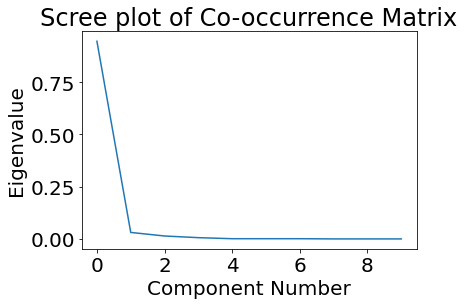

In [94]:
plt.plot(np.arange(len(var_explained[:10])), var_explained[:10])
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.title("Scree plot of Co-occurrence Matrix")

In [95]:
cooc_matrix.index

Index(['V1A1D1P1F1', 'V1A1D1P1F2', 'V1A1D1P2F1', 'V1A1D1P2F2', 'V1A1D2P1F1',
       'V1A1D2P1F2', 'V1A1D2P2F1', 'V1A1D2P2F2', 'V1A2D1P1F1', 'V1A2D1P1F2',
       'V1A2D1P2F1', 'V1A2D1P2F2', 'V1A2D2P1F1', 'V1A2D2P1F2', 'V1A2D2P2F1',
       'V1A2D2P2F2', 'V2A1D1P1F1', 'V2A1D1P1F2', 'V2A1D1P2F1', 'V2A1D1P2F2',
       'V2A1D2P1F1', 'V2A1D2P1F2', 'V2A1D2P2F1', 'V2A1D2P2F2', 'V2A2D1P1F1',
       'V2A2D1P1F2', 'V2A2D1P2F1', 'V2A2D1P2F2', 'V2A2D2P1F1', 'V2A2D2P1F2',
       'V2A2D2P2F1', 'V2A2D2P2F2'],
      dtype='object', name='bin')

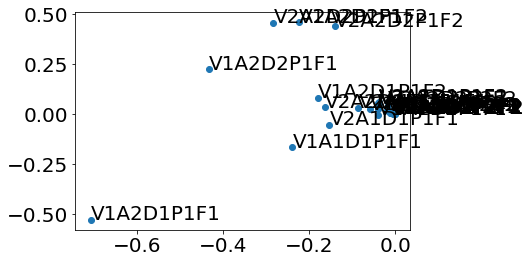

In [96]:
plt.scatter(P[:, 0], P[:, 1])
for a, b, label in zip(P[:, 0], P[:, 1], cooc_matrix.index):
    plt.text(a, b, label)

In [155]:
def mds_visualization_2(data, labels, feature, delegate):
    plt.rcParams.update({"font.size": 20})
    embedding = MDS(n_components=2, random_state=42)
    F_lowdim = embedding.fit_transform(data)
    print(F_lowdim.shape)
    fig = plt.figure(figsize=(20, 10))
    low_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "1", feature)]).astype(int)
    high_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "2", feature)]).astype(int)
    plt.plot(F_lowdim[low_val, 0], F_lowdim[low_val, 1], "bo", markersize=12, label=f"Low {feature}")
    plt.plot(F_lowdim[high_val, 0], F_lowdim[high_val, 1], "gs", markersize=12, label=f"High {feature}")
    plt.legend()
    # for i in range(len(F_lowdim)):
    #     plt.text(F_lowdim[i,0]*1.05, F_lowdim[i,1]*1.01, labels[i],fontsize=17)

    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(f"MDS Plot of Semantic Situation Space ({feature})")



In [101]:
def mds_visualization_4(data, labels, feature, delegate):
    plt.rcParams.update({"font.size": 20})
    embedding = MDS(n_components=2, random_state=42)
    F_lowdim = embedding.fit_transform(data)
    print(F_lowdim.shape)
    fig = plt.figure(figsize=(20, 10))
    low_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "1", feature)]).astype(int)
    midlow_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "2", feature)]).astype(int)
    midhigh_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "3", feature)]).astype(int)
    high_val = np.array([idx for idx, label in enumerate(labels) if delegate(label, "4", feature)]).astype(int)
    plt.plot(F_lowdim[low_val, 0], F_lowdim[low_val, 1], "bo", markersize=12, label=f"Low {feature}")
    plt.plot(F_lowdim[midlow_val, 0], F_lowdim[midlow_val, 1], "ro", markersize=12, label=f"Mid-low {feature}")
    plt.plot(F_lowdim[midhigh_val, 0], F_lowdim[midhigh_val, 1], "ys", markersize=12, label=f"Mid-high {feature}")
    plt.plot(F_lowdim[high_val, 0], F_lowdim[high_val, 1], "gs", markersize=12, label=f"High {feature}")
    plt.legend()
    for i in range(len(F_lowdim)):
        plt.text(F_lowdim[i,0]*1.05, F_lowdim[i,1]*1.01, labels[i],fontsize=17)

    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(f"MDS Plot of Semantic Situation Space ({feature})")
    plt.show()



/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(32, 2)
(32, 2)
(32, 2)


/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(32, 2)
(32, 2)


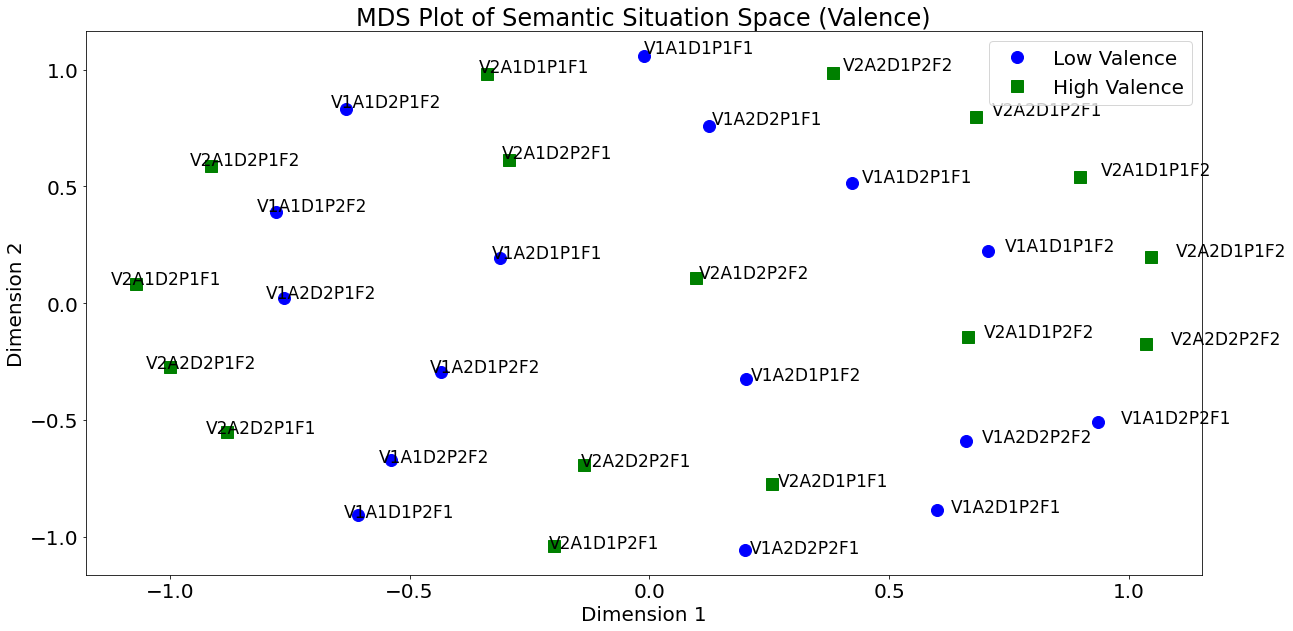

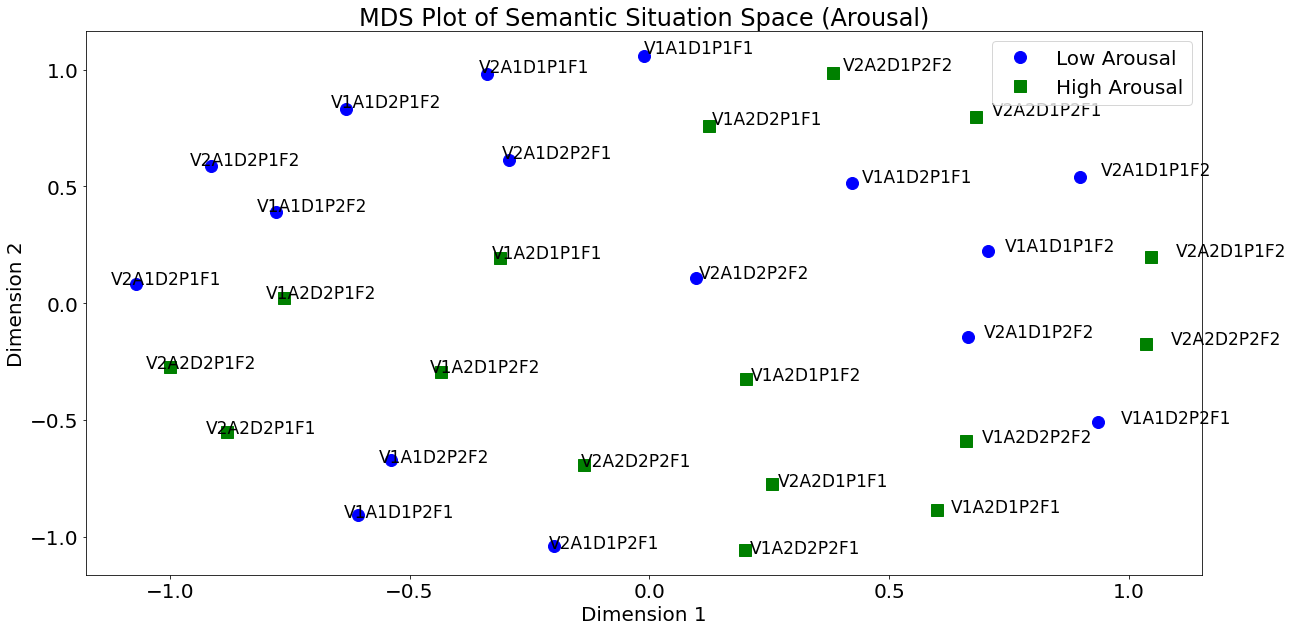

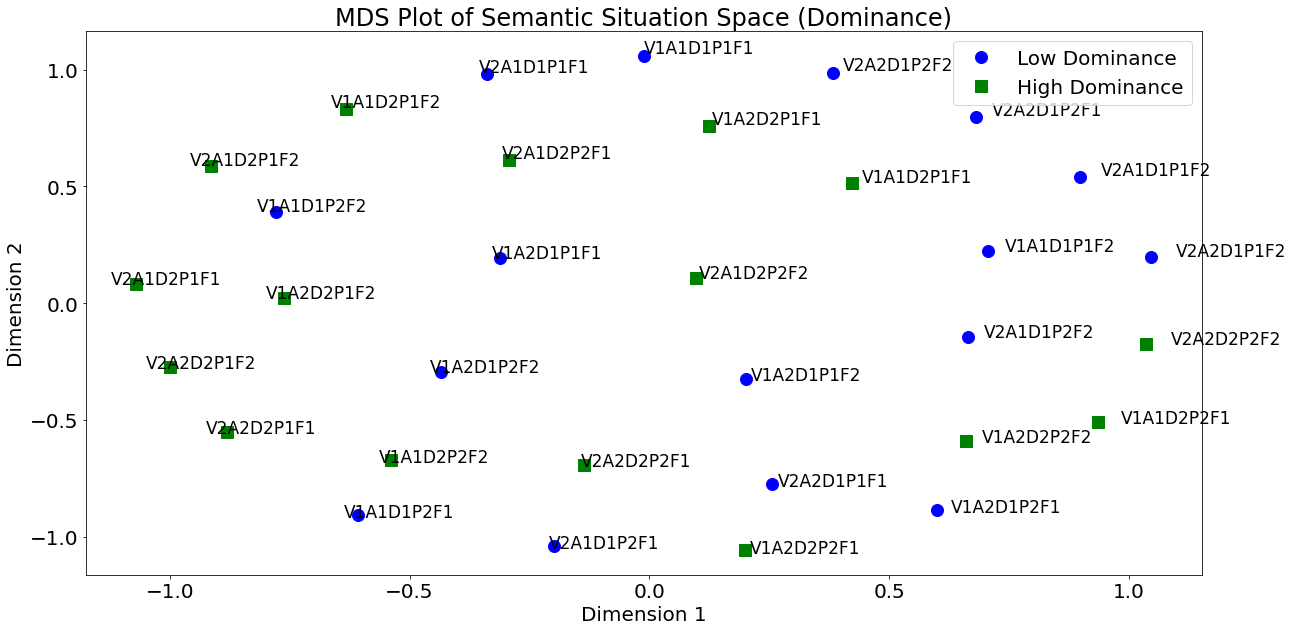

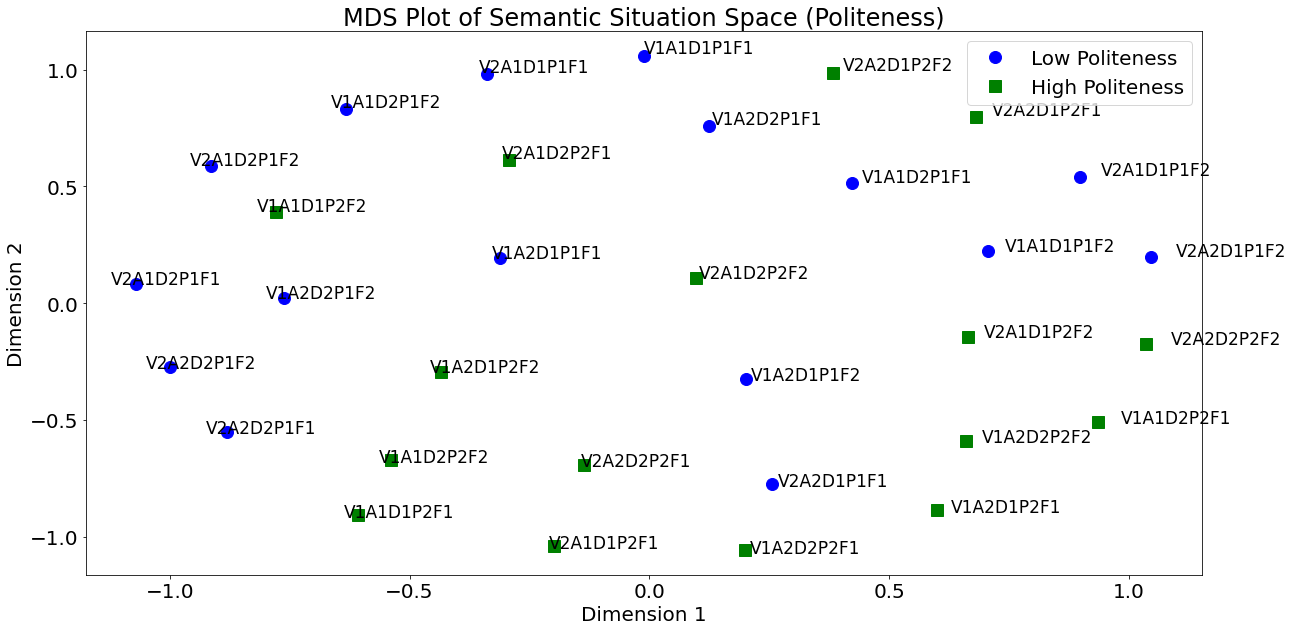

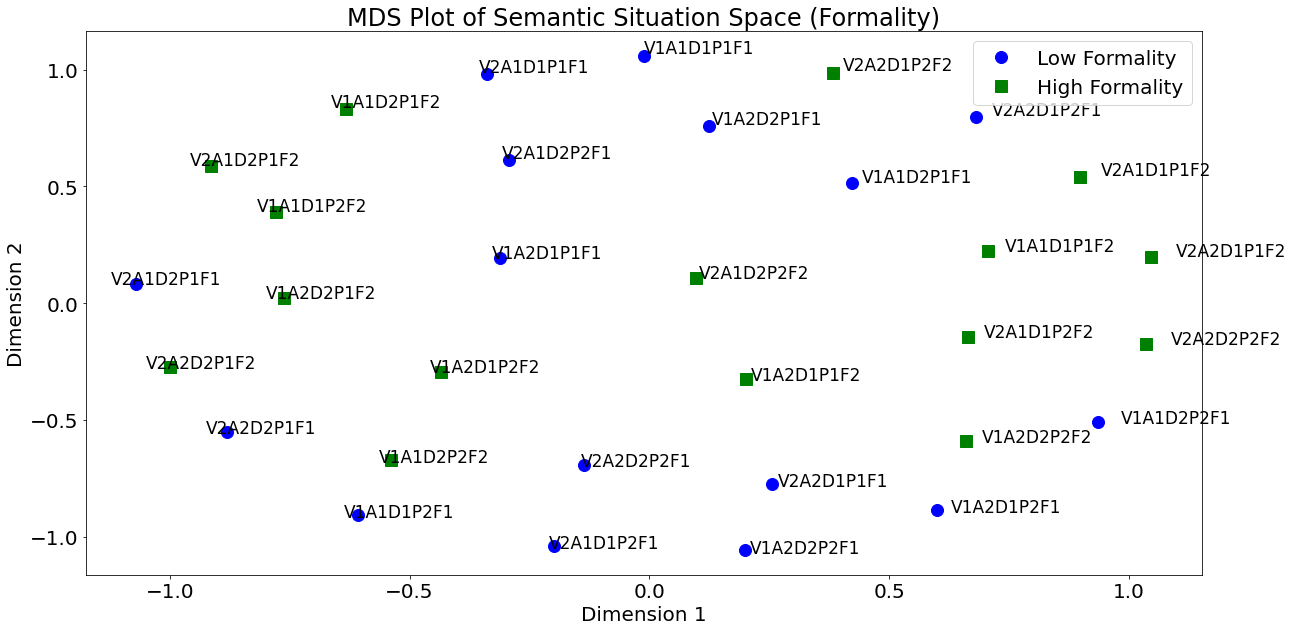

In [102]:
feature_to_index = {
    "Valence": 1,
    "Arousal": 3,
    "Dominance": 5,
    "Politeness": 7,
    "Formality": 9
}

name_to_data = {
    "VADPF": x.to_numpy(),
    "cooc": cooc_matrix_np,
    "derived": P
}
feature = "Valence"
mds_visualization_2(name_to_data['derived'], cooc_matrix.index, "Valence", lambda x, y, z: x[feature_to_index[z]] == y)
mds_visualization_2(name_to_data['derived'], cooc_matrix.index, "Arousal", lambda x, y, z: x[feature_to_index[z]] == y)
mds_visualization_2(name_to_data['derived'], cooc_matrix.index, "Dominance", lambda x, y, z: x[feature_to_index[z]] == y)
mds_visualization_2(name_to_data['derived'], cooc_matrix.index, "Politeness", lambda x, y, z: x[feature_to_index[z]] == y)
mds_visualization_2(name_to_data['derived'], cooc_matrix.index, "Formality", lambda x, y, z: x[feature_to_index[z]] == y)


In [65]:
def get_distance_matrix(data, metric=None):
    """Return a distance matrix that can be used to calculate distance
    between clusters, using a supplied metric.

    By default calculate cosine distance.
    """
    if metric is None:
        return pdist(data, metric="cosine")
    else:
        return pdist(data, metric=metric)


def visualize_mds(data, labels, title, filename):
    """Data should be a sense count x feature matrix where each row corresponds to the centroid
    of a sense.
    
    Labels should be the same as length data"""
    assert len(data) == len(labels)

    embedding = MDS(n_components=2)
    F_lowdim = embedding.fit_transform(data)

    fig = plt.figure(figsize=(20, 10))
    plt.plot(F_lowdim[:, 0], F_lowdim[:, 1], "bo", markersize=12)

    for i in range(len(F_lowdim)):
        plt.text(F_lowdim[i,0]*1.05, F_lowdim[i,1]*1.01, labels[i],fontsize=17)
    
    plt.xlabel('Dimension 1')    
    plt.ylabel('Dimension 2')
    plt.title(title)

    # plt.savefig(filename)

In [45]:
cooc_matrix_np.shape

(599, 4540)

In [58]:
from sklearn.metrics.pairwise import cosine_similarity

In [124]:
from scipy.spatial.distance import cdist

In [167]:
new_P.shape

(32, 3)

In [168]:
original_dist_matrix = cosine_similarity(cooc_matrix_np)
derived_dist_matrix = cosine_similarity(new_P)
# original_dist_matrix = cdist(cooc_matrix_np, cooc_matrix_np)
# derived_dist_matrix = cdist(new_P, new_P)

In [161]:
original_dist_matrix.shape

(32, 32)

In [150]:
original_dist_matrix

array([[1.        , 0.94712885, 0.94329468, ..., 0.79204037, 0.74832961,
        0.70901053],
       [0.94712885, 1.        , 0.89392284, ..., 0.87304939, 0.71946317,
        0.75049865],
       [0.94329468, 0.89392284, 1.        , ..., 0.81916073, 0.86887837,
        0.83431733],
       ...,
       [0.79204037, 0.87304939, 0.81916073, ..., 1.        , 0.7651386 ,
        0.87289313],
       [0.74832961, 0.71946317, 0.86887837, ..., 0.7651386 , 1.        ,
        0.93323847],
       [0.70901053, 0.75049865, 0.83431733, ..., 0.87289313, 0.93323847,
        1.        ]])

In [169]:
derived_dist_matrix

array([[ 1.        ,  0.44757755,  0.66551966, ..., -0.21077835,
         0.27472826,  0.09574788],
       [ 0.44757755,  1.        ,  0.282701  , ...,  0.55334019,
         0.0593849 ,  0.16572778],
       [ 0.66551966,  0.282701  ,  1.        , ...,  0.33731077,
         0.8995548 ,  0.79703975],
       ...,
       [-0.21077835,  0.55334019,  0.33731077, ...,  1.        ,
         0.5201151 ,  0.72656885],
       [ 0.27472826,  0.0593849 ,  0.8995548 , ...,  0.5201151 ,
         1.        ,  0.96188266],
       [ 0.09574788,  0.16572778,  0.79703975, ...,  0.72656885,
         0.96188266,  1.        ]])

In [152]:
derived_dist_matrix.shape

(32, 32)

/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(32, 2)
(32, 2)


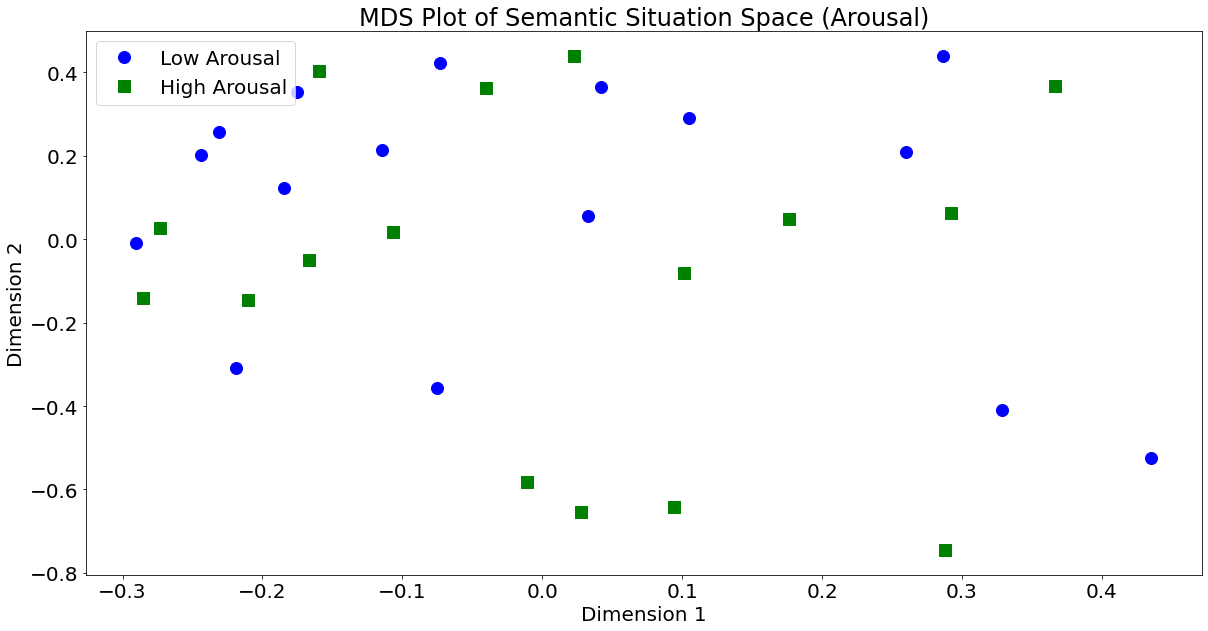

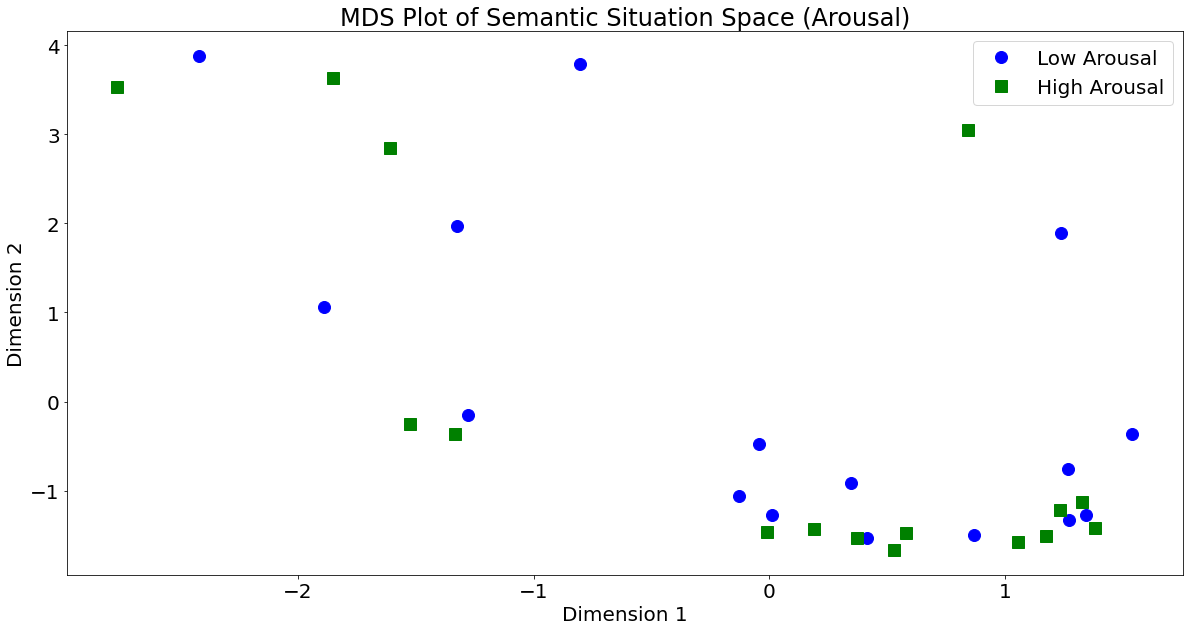

In [170]:
curr_feature = "Arousal"
mds_visualization_2(original_dist_matrix, cooc_matrix.index, curr_feature, lambda x, y, z: x[feature_to_index[z]] == y)
mds_visualization_2(derived_dist_matrix, cooc_matrix.index, curr_feature, lambda x, y, z: x[feature_to_index[z]] == y)


/u/jai/miniconda3/envs/venv37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(32, 2)


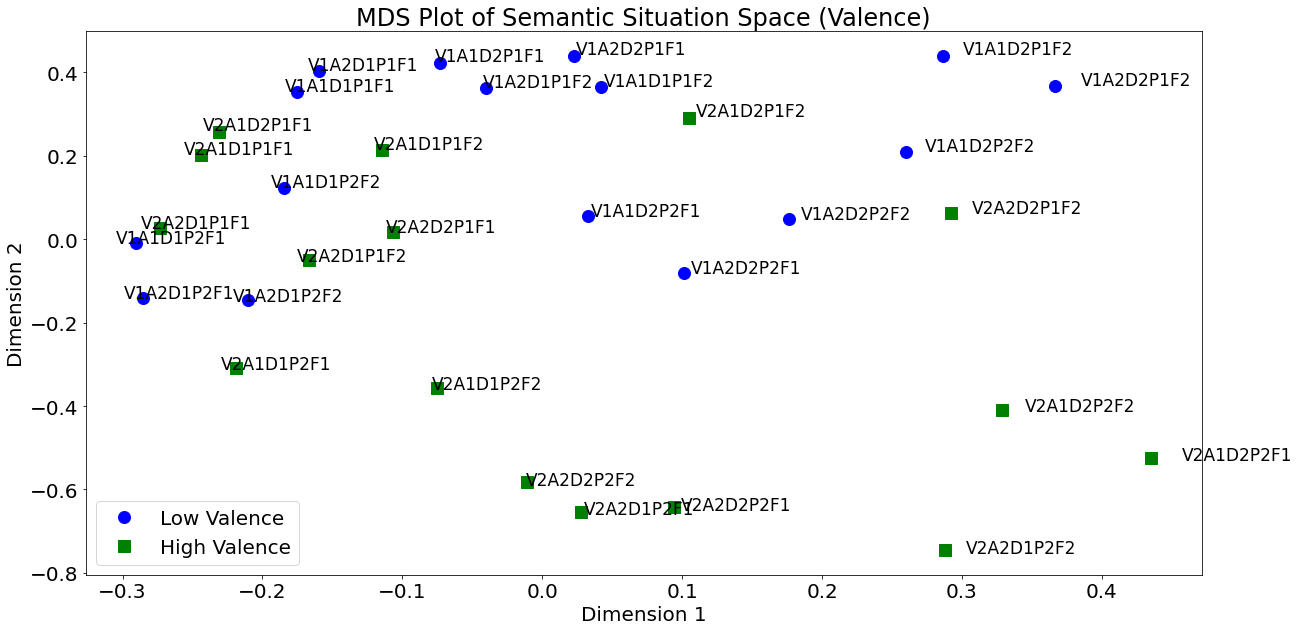

(599, 2)
123


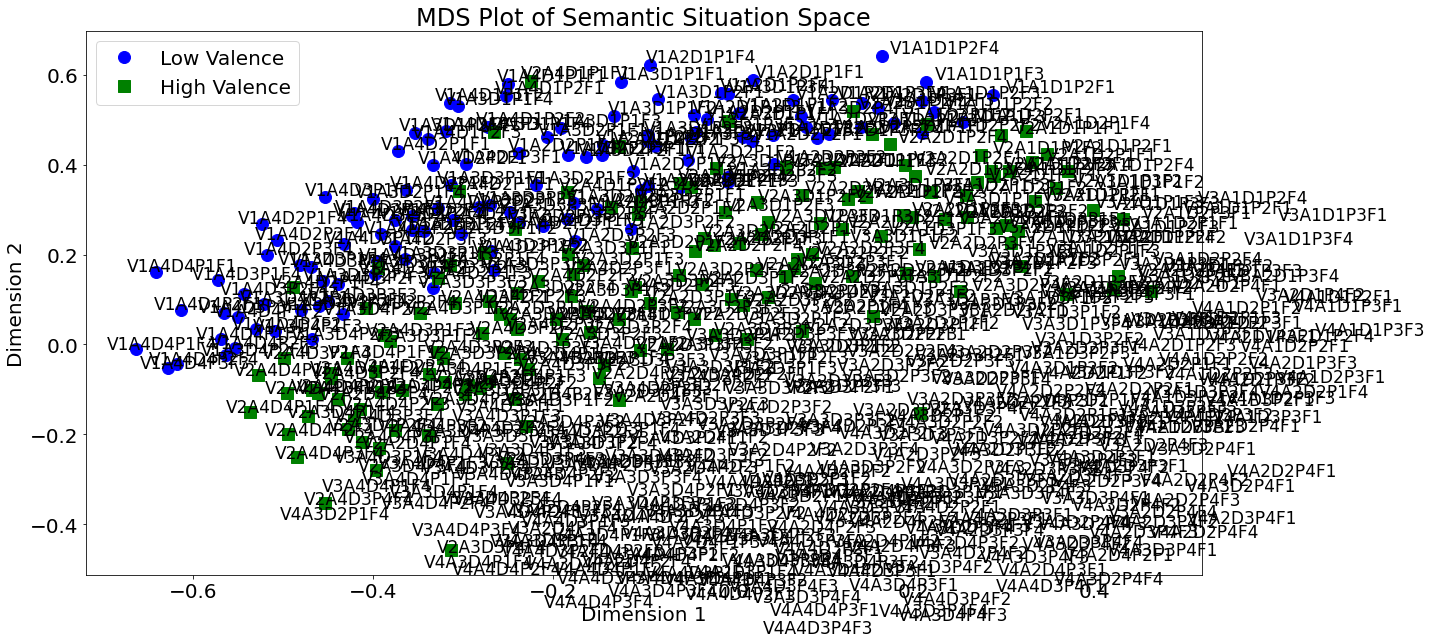

In [30]:

# labels = cooc_matrix.index
# embedding = MDS(n_components=2, random_state=42)
# F_lowdim = embedding.fit_transform(x.to_numpy())
# print(F_lowdim.shape)
# fig = plt.figure(figsize=(20, 10))
# low_valence = np.array([idx for idx, label in enumerate(labels) if label[1] == "1"]).astype(int)
# high_valence = np.array([idx for idx, label in enumerate(labels) if label[1] == "2"]).astype(int)
# print(high_valence[0])
# plt.plot(F_lowdim[low_valence, 0], F_lowdim[low_valence, 1], "bo", markersize=12, label="Low Valence")
# plt.plot(F_lowdim[high_valence, 0], F_lowdim[high_valence, 1], "gs", markersize=12, label="High Valence")
# plt.legend()
# for i in range(len(F_lowdim)):
#     plt.text(F_lowdim[i,0]*1.05, F_lowdim[i,1]*1.01, labels[i],fontsize=17)

# plt.xlabel('Dimension 1')    
# plt.ylabel('Dimension 2')
# plt.title("MDS Plot of Semantic Situation Space")
# plt.rcParams.update({"font.size": 20})
